In [12]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import isnan

REMOVE_COLUMNS_REGION = ["CODIGO (WMO):", "DATA DE FUNDACAO:", "ESTACAO:"]
GET_COLUMNS_CLIMATE = [
    "Data",
    "Hora UTC",
    "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",
    "VENTO, VELOCIDADE HORARIA (m/s)",
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",
    "RADIACAO GLOBAL (Kj/m²)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)",
]

%matplotlib inline

#### Leitura dos arquivos sobre o clima

Arquivos baixados do site [inmet](https://portal.inmet.gov.br/dadoshistoricos) (arquivos de 2022)

In [3]:
climate_dir = "./data/2022"
list_df_station = []
list_df_climate = []

count = 0

for file_name in os.listdir(climate_dir):
    # Nossa tabela fato, utiliza o nome da UF, latitude, longitude e altitude
    df_station = pd.read_csv(
        f"{climate_dir}/{file_name}",
        delimiter=";",
        encoding="Windows 1252",
        nrows=7,
    ).set_index("REGIAO:").transpose().reset_index(drop=True)

    df_station = df_station.drop(columns=REMOVE_COLUMNS_REGION)

    df_station = df_station.rename(columns={"UF:":"UF",
                                            "LATITUDE:":"latitude",
                                            "LONGITUDE:":"longitude",
                                            "ALTITUDE:":"altitude"})


    df_climate = pd.read_csv(
        f"{climate_dir}/{file_name}",
        delimiter=";",
        encoding="Windows 1252",
        skiprows=8,
    ).dropna(how="all", subset=GET_COLUMNS_CLIMATE[2:]).get(GET_COLUMNS_CLIMATE)

    df_climate = df_climate.rename_axis("id")

    df_climate = df_climate.rename(columns={"CODIGO (WMO)": "id",
                                  "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "precipTotalHorario",
                                  "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)": "tempAr",
                                  "VENTO, VELOCIDADE HORARIA (m/s)": "ventoVeloHoraria",
                                  "RADIACAO GLOBAL (Kj/m²)": "radGlobal",
                                  "UMIDADE RELATIVA DO AR, HORARIA (%)": "umidRelAr"})
    
    #Adicionando id da FK
    df_climate["id_regiao"] = count
    count = count+1
    


    list_df_station.append(df_station)
    list_df_climate.append(df_climate)

In [4]:
df_all_station = pd.concat(list_df_station, ignore_index=True)
df_all_station = df_all_station.rename_axis("id")
df_all_station.to_csv("./data/dim_regiao.csv", sep=";")

In [5]:
df_all_climate = pd.concat(list_df_climate, ignore_index=True)
df_all_climate = df_all_climate.rename_axis("id")
df_all_climate.to_csv("./data/fato_dados_meteorologicos.csv", sep=";")

In [6]:
# Create timestamp from Date and UTC Time
def create_timestamp(row):
    return dt.datetime.strptime(f"{row['Data']} {row['Hora UTC']}", "%Y/%m/%d %H%M UTC")

df_all_climate["timestamp"] = df_all_climate.apply(create_timestamp, axis=1)
df_all_climate = df_all_climate.drop(["Data", "Hora UTC"], axis=1)

In [7]:
# Converter as colunas relevantes para tipo numérico, se necessário
df_all_climate['precipTotalHorario'] = pd.to_numeric(df_all_climate['precipTotalHorario'], errors='coerce')
df_all_climate['tempAr'] = pd.to_numeric(df_all_climate['tempAr'], errors='coerce')
df_all_climate['ventoVeloHoraria'] = pd.to_numeric(df_all_climate['ventoVeloHoraria'], errors='coerce')
df_all_climate['radGlobal'] = pd.to_numeric(df_all_climate['radGlobal'], errors='coerce')
df_all_climate['umidRelAr'] = pd.to_numeric(df_all_climate['umidRelAr'], errors='coerce')

df_all_climate.set_index('timestamp', inplace=True)


In [37]:
# df_all_climate.hist(figsize=(20, 6.4), grid=False)
print(df_all_climate.index.drop_duplicates())

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8760, freq=None)


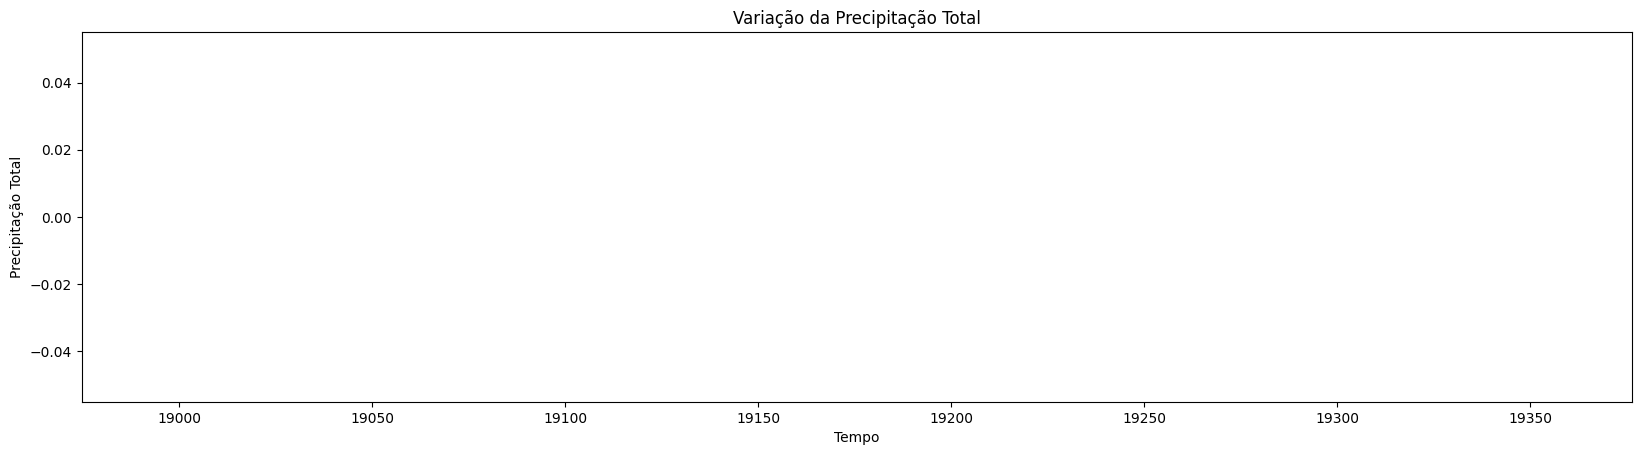

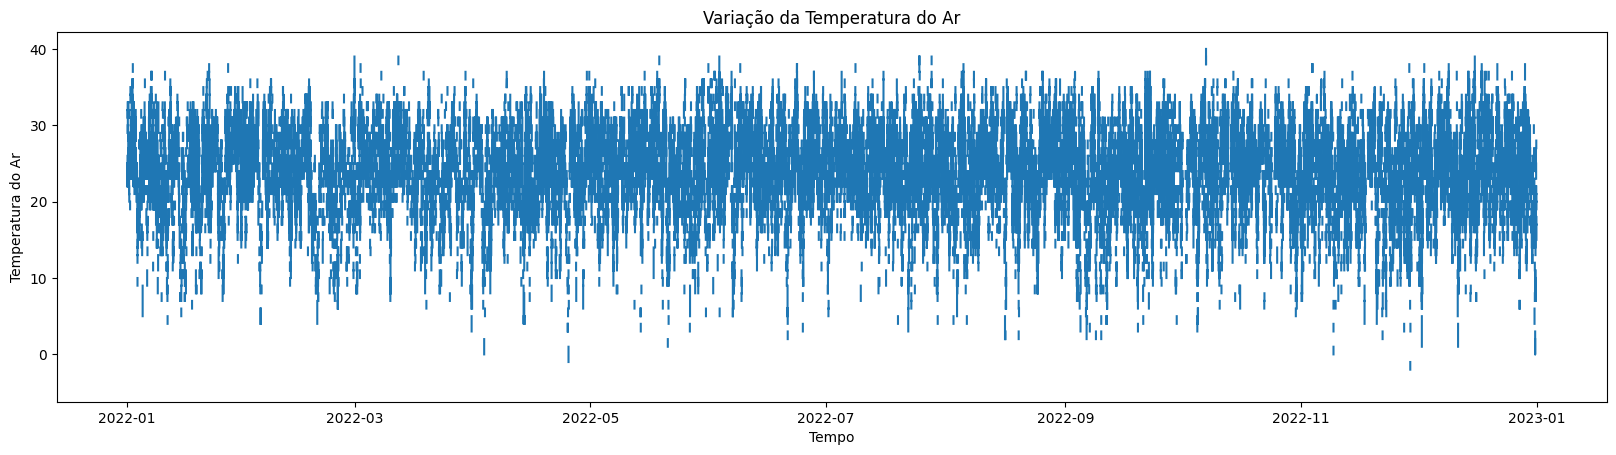

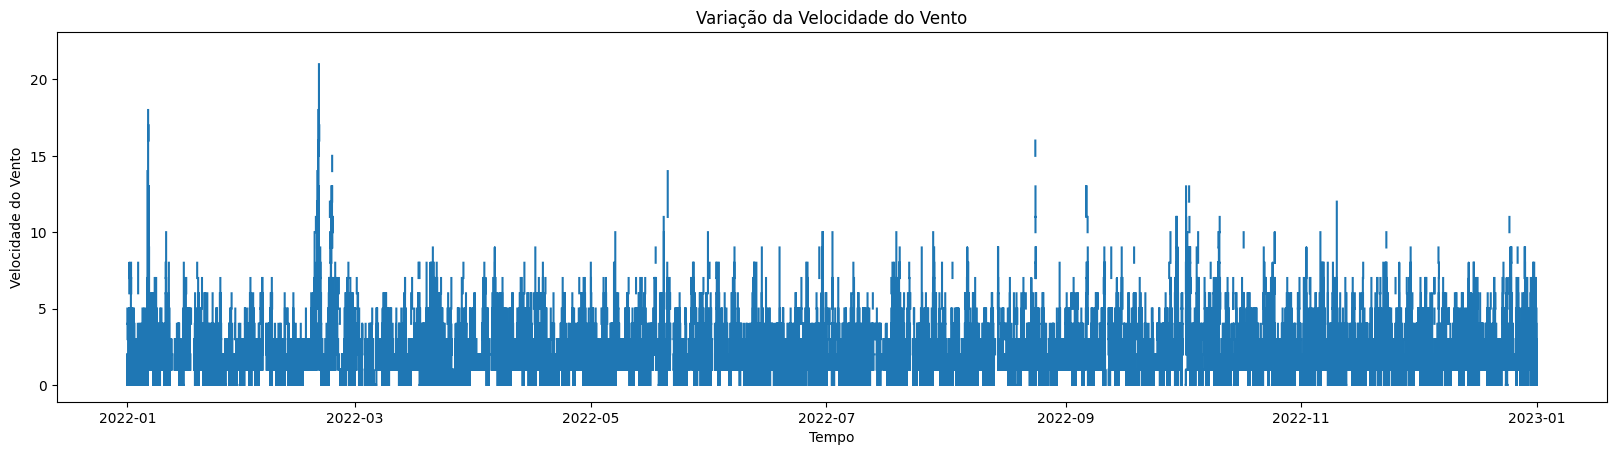

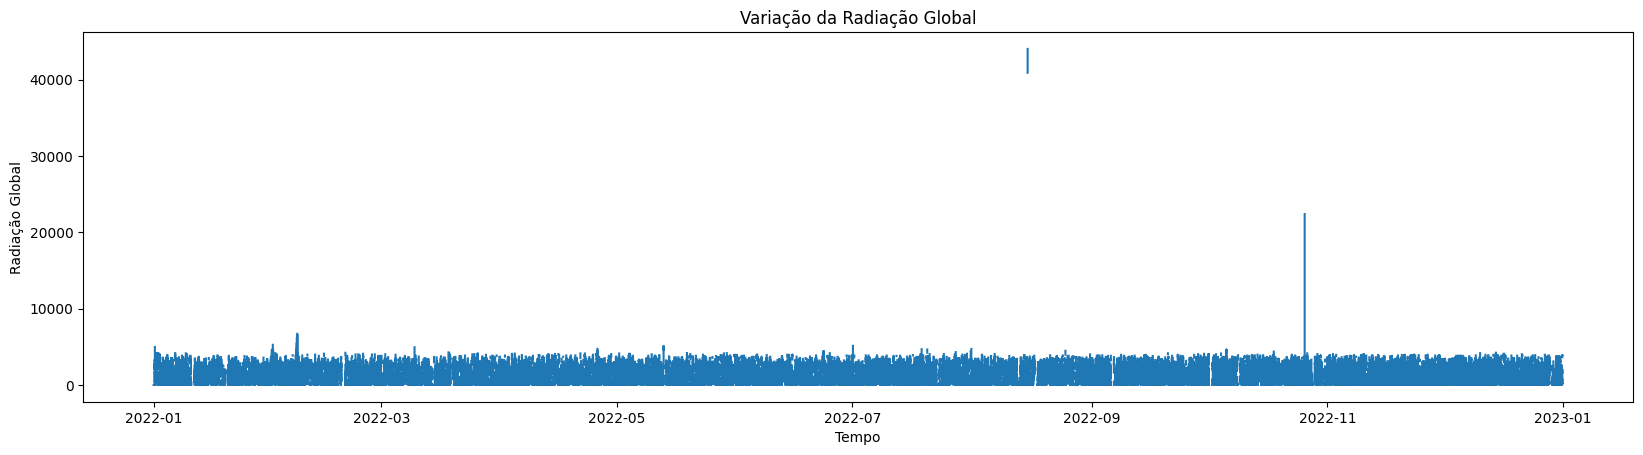

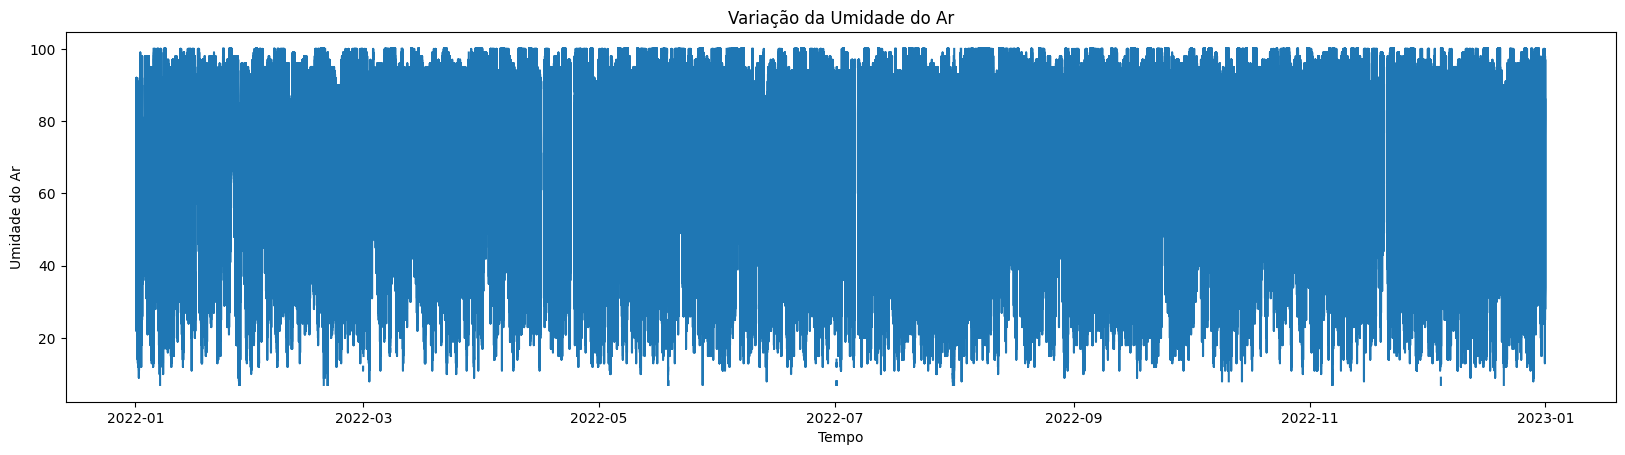

In [38]:
# Criar gráfico de linhas para a precipitaçãoTotal
plt.figure(figsize=(20, 4.8))
plt.hist(df_all_climate['precipTotalHorario'], bins=(df_all_climate.index.drop_duplicates()))
plt.xlabel('Tempo')
plt.ylabel('Precipitação Total')
plt.title('Variação da Precipitação Total')
plt.show()

# Criar gráfico de linhas para a temperaturaAr
plt.figure(figsize=(20, 4.8))
plt.plot(df_all_climate.index, df_all_climate['tempAr'])
plt.xlabel('Tempo')
plt.ylabel('Temperatura do Ar')
plt.title('Variação da Temperatura do Ar')
plt.show()

# Criar gráfico de linhas para a velocidadeVento
plt.figure(figsize=(20, 4.8))
plt.plot(df_all_climate.index, df_all_climate['ventoVeloHoraria'])
plt.xlabel('Tempo')
plt.ylabel('Velocidade do Vento')
plt.title('Variação da Velocidade do Vento')
plt.show()

# Criar gráfico de linhas para a radiaçãoGlobal
plt.figure(figsize=(20, 4.8))
plt.plot(df_all_climate.index, df_all_climate['radGlobal'])
plt.xlabel('Tempo')
plt.ylabel('Radiação Global')
plt.title('Variação da Radiação Global')
plt.show()

# Criar gráfico de linhas para a humidadeAr
plt.figure(figsize=(20, 4.8))
plt.plot(df_all_climate.index, df_all_climate['umidRelAr'])
plt.xlabel('Tempo')
plt.ylabel('Umidade do Ar')
plt.title('Variação da Umidade do Ar')
plt.show()

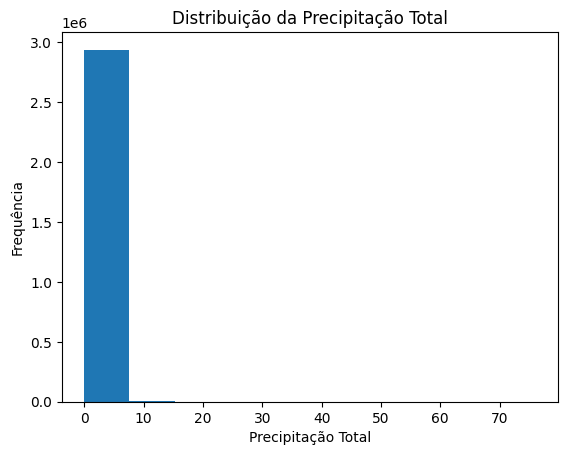

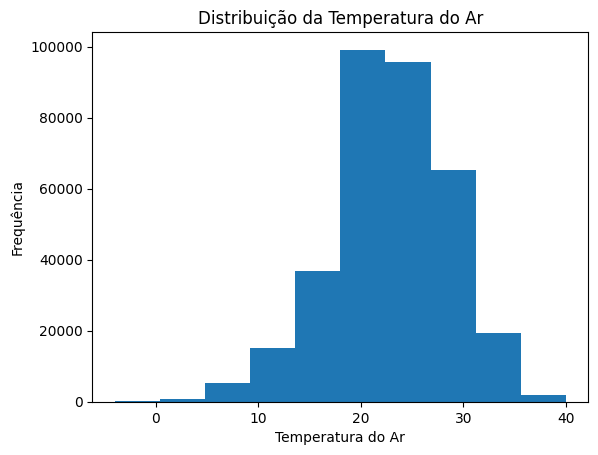

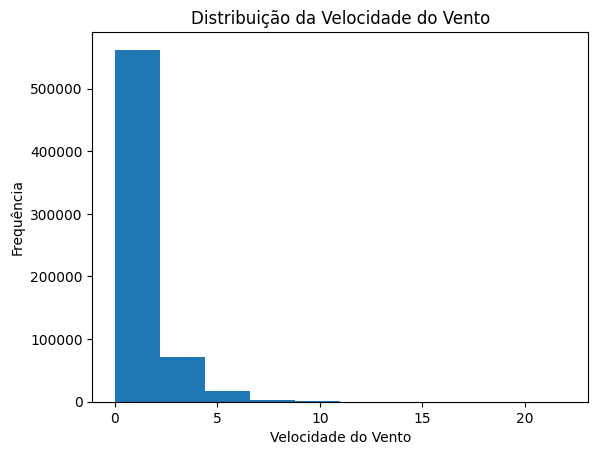

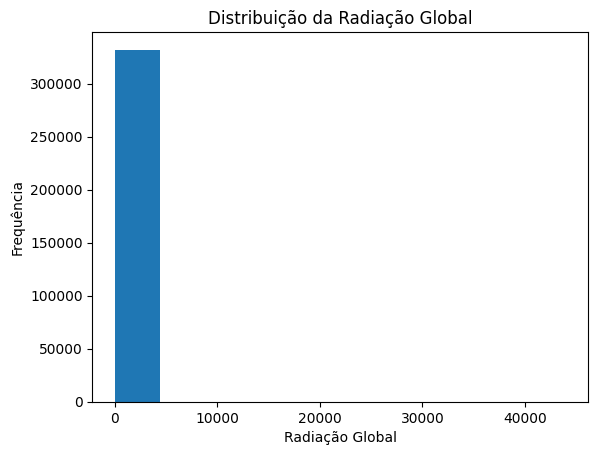

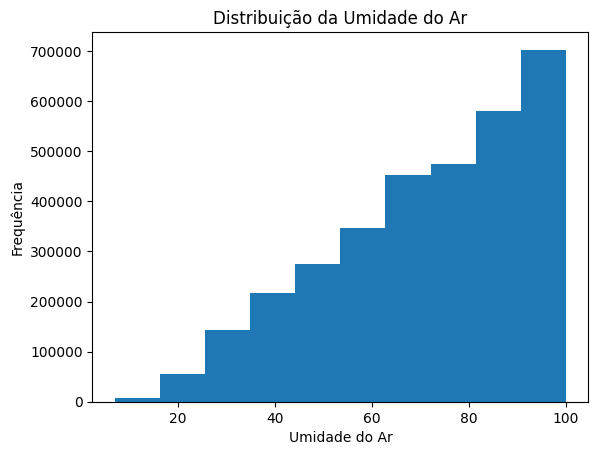

In [10]:
# Criar histograma para a precipitaçãoTotal
plt.hist(df_all_climate['precipTotalHorario'], bins=10)
plt.xlabel('Precipitação Total')
plt.ylabel('Frequência')
plt.title('Distribuição da Precipitação Total')
plt.show()

# Criar histograma para a temperaturaAr
plt.hist(df_all_climate['tempAr'], bins=10)
plt.xlabel('Temperatura do Ar')
plt.ylabel('Frequência')
plt.title('Distribuição da Temperatura do Ar')
plt.show()

# Criar histograma para a velocidadeVento
plt.hist(df_all_climate['ventoVeloHoraria'], bins=10)
plt.xlabel('Velocidade do Vento')
plt.ylabel('Frequência')
plt.title('Distribuição da Velocidade do Vento')
plt.show()

# Criar histograma para a radiaçãoGlobal
plt.hist(df_all_climate['radGlobal'], bins=10)
plt.xlabel('Radiação Global')
plt.ylabel('Frequência')
plt.title('Distribuição da Radiação Global')
plt.show()

# Criar histograma para a humidadeAr
plt.hist(df_all_climate['umidRelAr'], bins=10)
plt.xlabel('Umidade do Ar')
plt.ylabel('Frequência')
plt.title('Distribuição da Umidade do Ar')
plt.show()

In [11]:
df_all_climate

,precipTotalHorario,ventoVeloHoraria,tempAr,radGlobal,umidRelAr,id_regiao
timestamp,,,,,,
2022-03-14 15:00:00,0.0,NaN,NaN,NaN,NaN,0
2022-03-14 16:00:00,0.0,1.0,NaN,0.0,NaN,0
2022-03-14 17:00:00,0.0,1.0,NaN,0.0,NaN,0
2022-03-14 18:00:00,0.0,NaN,NaN,0.0,NaN,0
2022-03-14 19:00:00,NaN,NaN,NaN,0.0,NaN,0
...,...,...,...,...,...,...
2022-12-31 19:00:00,0.0,2.0,NaN,NaN,54.0,566
2022-12-31 20:00:00,0.0,NaN,NaN,NaN,62.0,566
2022-12-31 21:00:00,0.0,NaN,NaN,NaN,76.0,566
